#Hello World in commplax

## Install dependencies (expand sub-cell to see details)

### Install [JAX](https://github.com/google/jax)

In [1]:
!pip install --upgrade pip
# Jaxlib-GPU binary is hosted in Google's repo
!pip install --upgrade jax==0.2.13 jaxlib==0.1.67+cuda111 -f https://storage.googleapis.com/jax-releases/jax_releases.html

     |████████████████████████████████| 1.6MB 7.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
     |████████████████████████████████| 194.6 MB 40 kB/s 
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.1.66+cuda110
    Uninstalling jaxlib-0.1.66+cuda110:
      Successfully uninstalled jaxlib-0.1.66+cuda110


### Install [Commplax](https://github.com/remifan/commplax)

In [2]:
!pip install http://github.com/remifan/commplax/archive/4692dfe77ef343aaaf25e1385a1360694125b5b4.zip

     \ 181 kB 5.9 MB/s
  Created wheel for commplax: filename=commplax-1.0-py3-none-any.whl size=40331 sha256=70a612764f1651b671a35ebb513f057659b28e9b3aa9db14f60b94a50b6d5962
  Stored in directory: /tmp/pip-ephem-wheel-cache-nbvsrtg8/wheels/2e/87/9c/d7cedae69528da680cb82bb92223b78ea7b5939f08fc128093
  Created wheel for quantumrandom: filename=quantumrandom-1.9.0-py3-none-any.whl size=9131 sha256=000e2df15be8401a5fc9a877284e511a5fd2b61ca2b357ab5492504fd92ce788
  Stored in directory: /root/.cache/pip/wheels/99/08/4f/618080011e884de267d956ba1e96144f1071417dd75f480de4
Successfully built commplax quantumrandom


### Install DVC

In [3]:
!pip install dvc[s3]

     |████████████████████████████████| 639 kB 7.2 MB/s 
     |████████████████████████████████| 296 kB 15.4 MB/s 
     |████████████████████████████████| 101 kB 8.4 MB/s 
     |████████████████████████████████| 3.1 MB 15.5 MB/s 
     |████████████████████████████████| 107 kB 59.9 MB/s 
     |████████████████████████████████| 166 kB 70.5 MB/s 
     |████████████████████████████████| 44 kB 3.4 MB/s 
     |████████████████████████████████| 529 kB 55.5 MB/s 
     |████████████████████████████████| 203 kB 60.9 MB/s 
     |████████████████████████████████| 75 kB 4.8 MB/s 
     |████████████████████████████████| 40 kB 6.8 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 131 kB 61.2 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 7.6 MB 61.8 MB/s 
     |████████████████████████████████| 153 kB 73.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |██████████████████████

## Download transmission data

In [4]:
!dvc get https://github.com/remifan/LabPtPTm1 data/815km_SSMF/DP16QAM_RRC0.2_28GBd_1ch/LP-6_5.h5
!dvc get https://github.com/remifan/LabPtPTm1 data/source/16QAM65536_mt19937ar_src1.h5

## Demodulate DP-16QAM ~815km SSMF transmission signal using commplax

In [16]:
from jax import numpy as jnp, jit
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import h5py
from commplax import xop, comm, xcomm, adaptive_filter as af, plot as cplt

In [6]:
with h5py.File("LP-6_5.h5", "r") as hf:
  y = hf['recv'][...]
  sr = hf.attrs['samplerate']
  br = hf.attrs['baudrate']
  dist = hf.attrs['distance']
  spans = hf.attrs['spans']
  lpw = hf.attrs['lpw']
  mf = hf.attrs['modformat']

with h5py.File("16QAM65536_mt19937ar_src1.h5", "r") as hf:
  x = hf['sent'][...]

# meta data
print('shape of y: %s (preprocessed waveforms, resampled to 2 samples/symbol): ' % str(y.shape))
print('shape of x: %s (sent symbols, emulating PDM by delaying 1 polarization): ' % str(x.shape))
print('sample rate: %.1f GHz' % (sr / 1e9))
print('baud rate: %.1f GBd' % (br / 1e9))
print('launched power: %.3f mW' % (lpw * 1e3))
print('link distance: %.1f km (measured)' % (dist / 1e3))
print('number of spans: %d' % spans)

shape of y: (3500000, 2) (preprocessed waveforms, resampled to 2 samples/symbol): 
shape of x: (65536, 2) (sent symbols, emulating PDM by delaying 1 polarization): 
sample rate: 56.0 GHz
baud rate: 28.0 GBd
launched power: 0.871 mW
link distance: 815.0 km (measured)
number of spans: 10


In [7]:
# DC-block and normalize raw signal
y -= np.mean(y, axis=0)
y =  xcomm.normpower(y, real=True) / np.sqrt(2)

# mesuare CD using FrFT-based algorithms
# first time run could be slightly slow to warmup GPU

CD = xcomm.measure_cd(y[10000:30000, 0], sr, bins=2000)[0] / dist
print('estimated CD = %.4g s/m^2' % CD)

estimated CD = 1.669e-05 s/m^2


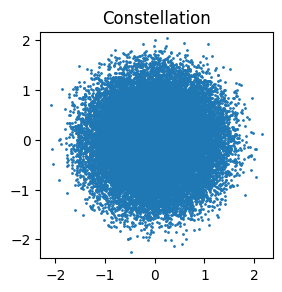

In [9]:
# 1 step/span time domain digital back propogation

D_fir_taps = 301 # number of taps for CD compensation operator (namely D op.)
param_D, param_N = comm.dbp_params(sr, dist/spans, spans, D_fir_taps, fiber_dispersion=CD)
y_dbp = xcomm.dbp_timedomain(y / jnp.sqrt(2), param_D, 0.5 * lpw * param_N) * jnp.sqrt(2)

# scatterplot X-Pol signal to compared with the ones shown below
cplt.scatter(y_dbp[1000000:1020000, 0])

In [22]:
# make adaptive filters' functonal utilies
cma_init, cma_update, cma_map = af.mucma()
rde_init, rde_update, rde_map = af.rde()
# create 2-cpr AF array with each cpr module implemented dimention(pol.)-wise 
cpr_init, cpr_update, cpr_map = af.array(af.cpane_ekf, 2)()

iterate = jit(af.iterate, backend='cpu', static_argnums=0)

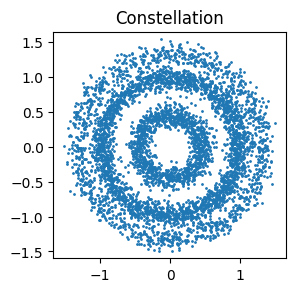

In [23]:
taps = 19  # MIMO filter tap number
sps = 2  # T/2-spaced adaptive equalizer

# framing signal to enable map function
yf = jnp.array(xop.frame(y_dbp, taps, sps))

# get initial weights
s0 = cma_init(taps=19)
# warm-up MIMO via CMA using a short sequence
(w0, *_,), (ws1, loss1) = iterate(cma_update, 0, s0, yf[:20000])[1]
# switch to RDE that inherits CMA'weights
_, (ws2, loss2) = iterate(rde_update, 0, w0, yf[20000:])[1]
# map to get MIMO out
loss = jnp.concatenate([loss1, loss2], axis=0)
ws = jnp.concatenate([ws1, ws2], axis=0)
x_hat = rde_map(ws, yf)

cplt.scatter(x_hat[500000:505000, 1])

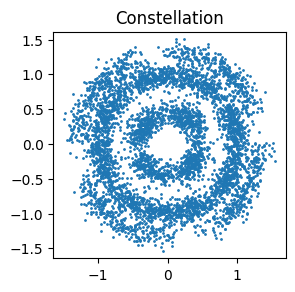

In [24]:
# Frequency-offset coarse compensation using simple 4th-power-fft-max method
fo, fo_metric = xcomm.foe_mpowfftmax(x_hat[100000:200000], M=4)
fo = jnp.mean(fo) # average estimated FO from X and Y pol.
T = jnp.arange(len(x_hat))
x_hat *= jnp.tile(jnp.exp(-1j * fo * T)[:, None], (1, 2))

cplt.scatter(x_hat[500000:505000, 0])

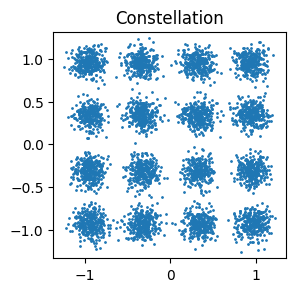

In [26]:
# residual FO removal, carrier phase recovery via 1-tap CPANE-EKF
cpr_state = cpr_init()
cpr_update, (phi, cpr_decision) = iterate(cpr_update, 0, cpr_state, x_hat)[1]
x_hat = cpr_map(phi, x_hat)

# scatterplot signal after this stage
cplt.scatter(x_hat[500000:505000, 0])

X/Y delay from PDME: -408


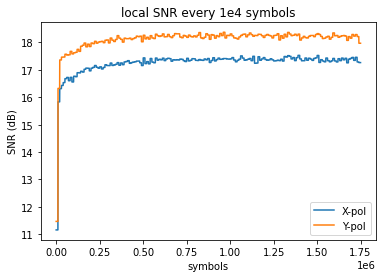

,BER,QSq,SNR
dim0,0.000396,10.515690,17.358774
dim1,0.000126,11.272436,18.220541
total,0.000261,10.805462,17.768312


In [27]:
# check if singularity is present
print("X/Y delay from PDME: %d" % (xcomm.dimsdelay(x_hat)))

# synchronize sent symbols
z = xcomm.repalign(x_hat, x, skipfirst=len(x_hat) - 100000)

# remove phase ambiguity and rescale signal
x_hat = xcomm.alignphase(x_hat, z) * xcomm.qamscale(mf)

# check DSP convergence
snr_local = comm.qamqot_local(x_hat, z)['SNR'][:, :2]
fig = plt.figure()
plt.plot(snr_local)
plt.title('local SNR every 1e4 symbols')
plt.xlabel('symbols')
plt.ylabel('SNR (dB)')
plt.legend(['X-pol', 'Y-pol']);
plt.show()

# calc. effecitve QoT (BER, Q-factor (dB) and SNR (dB))
# %load_ext google.colab.data_table
comm.qamqot(x_hat[300000:-20000], z[300000:-20000])